<a href="https://colab.research.google.com/github/luis8choa/Computer_Vision/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lectura y visualizacion de un dataset de segmentation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/segmentation_projects_datasets/camseq.zip"

Archive:  /content/drive/MyDrive/segmentation_projects_datasets/camseq.zip
replace 0016E5_07959.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 0016E5_07959.png        
  inflating: 0016E5_07959_L.png      
  inflating: 0016E5_07961.png        
  inflating: 0016E5_07961_L.png      
  inflating: 0016E5_07963.png        
  inflating: 0016E5_07963_L.png      
  inflating: 0016E5_07965.png        
  inflating: 0016E5_07965_L.png      
  inflating: 0016E5_07967.png        
  inflating: 0016E5_07967_L.png      
  inflating: 0016E5_07969.png        
  inflating: 0016E5_07969_L.png      
  inflating: 0016E5_07971.png        
  inflating: 0016E5_07971_L.png      
  inflating: 0016E5_07973.png        
  inflating: 0016E5_07973_L.png      
  inflating: 0016E5_07975.png        
  inflating: 0016E5_07975_L.png      
  inflating: 0016E5_07977.png        
  inflating: 0016E5_07977_L.png      
  inflating: 0016E5_07979.png        
  inflating: 0016E5_07979_L.png      
  inflating: 0016E5_079

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [ ]:
dataset_path = "./" #Ubicacion de los archivos descomprimidos
filenames = os.listdir(dataset_path)
filenames.sort()

image_list = []
masks_list = []
for filename in filenames:
  if len(filename.split(".")) > 1 and filename.split(".")[1][:3] == "png":
  #Descartamos demas archivos, solo nos quedamos con archivos .png
  # (imagenes o mascaras).
  #Deben tener mas de dos partes luego de split y debe poseer tres
  #caracteres luego del punto (segunda parte del split = 1)

    if (filename.split(".")[0][-2:] == "_L"):
    #Dividimos el filename en el punto, nos quedamos con la primera
    #parte de la division(0), mas especificamente con los ultimos dos
    #caracteres y validamos si se trata de una mascara buscando
    # el caracter "_L"
      masks_list.append(dataset_path + "/" + filename)
    else:
      image_list.append(dataset_path + "/" + filename)


In [ ]:
len(masks_list), len(image_list)

(101, 101)

In [ ]:
train_input_img_paths, val_input_img_paths, train_target_mask_paths, val_target_mask_paths  = train_test_split(image_list, masks_list, test_size=0.2, random_state=42)


In [ ]:
def load_data(images_path, masks_path):
  samples = {"images": [], "masks": []}

  for i in range(len(images_path)):
    img = plt.imread(images_path[i])
    mask = plt.imread(masks_path[i])

    img = cv2.resize(img,(256, 256))

    masks = cv2.resize(mask,(256,256))

    samples["images"].append(img)
    samples["masks"].append(masks)

    '''sample = {
      "images": np.array(samples["images"]),
      "masks": np.array(samples["masks"]),
      }'''

  return samples


    #convertiremos estos array, en numpy arrays para poder trabajar
    #con ellos de manera mas sencillas

In [ ]:
train_samples = load_data(train_input_img_paths, train_target_mask_paths)
test_samples = load_data(val_input_img_paths, val_target_mask_paths)

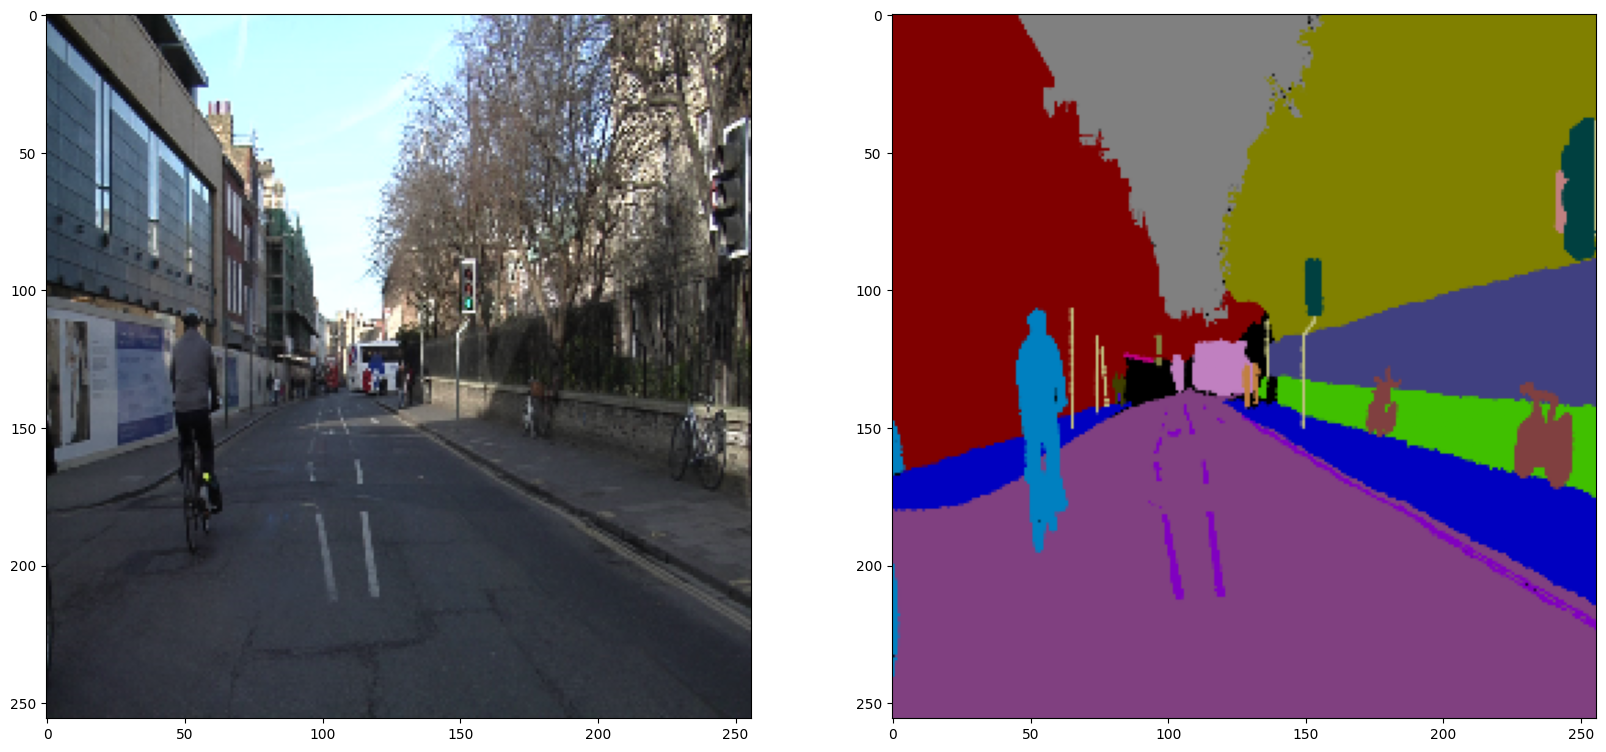

In [ ]:
#Visualizaion
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(train_samples["images"][10])
plt.subplot(1,2,2)
plt.imshow(train_samples["masks"][10])
plt.show()

# 2. Creando una red U-net para segmentación.

In [ ]:
def create_conv_block(input_tensor, num_filters):
  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,3), kernel_initializer="he_normal", padding="same")(input_tensor)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3,3), kernel_initializer="he_normal", padding="same")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  return x
  #Funcion para creacion de bloques convolucionales

In [ ]:
#Funcion de creacion de arquitectura de red completa U-net
def create_unet(input_shape, num_filters=16, dropout=0.1):

  #Encoder
  c1 = create_conv_block(input_shape, num_filters*1)
  #Vamos añadiendo cada vez mas filtros a nuestra capa convolucional
  #Segun nos vamos metiendo mas en profundidad
  p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
  p1 = tf.keras.layers.Dropout(dropout)(p1)

  c2 = create_conv_block(p1, num_filters*2)
  #Primer argumento es la salida anterior
  p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
  p2 = tf.keras.layers.Dropout(dropout)(p2)

  c3 = create_conv_block(p2, num_filters*4)
  p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
  p3 = tf.keras.layers.Dropout(dropout)(p3)

  c4 = create_conv_block(p3, num_filters*8)
  p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
  p4 = tf.keras.layers.Dropout(dropout)(p4)

  c5 = create_conv_block(p4, num_filters*16)



  #Decoder

  u6 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3,3), strides=(2,2), padding="same")(c5)
  #Capa convolucional transpuesta
  u6 = tf.keras.layers.concatenate([u6, c4])
  #Unimos parte de c4(parte anterior de encoder con el decoder)
  #Para hacer skip connections, Ayudara a pasar info de la parte
  #anterior a la posterior.

  u6 = tf.keras.layers.Dropout(dropout)(u6)
  c6 = create_conv_block(u6, num_filters*8)

  u7 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3,3), strides=(2,2), padding="same")(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = tf.keras.layers.Dropout(dropout)(u7)
  c7 = create_conv_block(u7, num_filters*4)

  u8 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3,3), strides=(2,2), padding="same")(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = tf.keras.layers.Dropout(dropout)(u8)
  c8 = create_conv_block(u8, num_filters*2)

  u9 = tf.keras.layers.Convolution2DTranspose(num_filters, (3,3), strides=(2,2), padding="same")(c8)
  u9 = tf.keras.layers.concatenate([u9, c1])
  u9 = tf.keras.layers.Dropout(dropout)(u9)
  c9 = create_conv_block(u9, num_filters)

  output = tf.keras.layers.Conv2D(3,(1,1), activation="sigmoid")(c9)
  #Mascara final sigmoide
  model = tf.keras.Model(inputs = [input_shape], outputs=[output])

  return model

In [ ]:
inputs = tf.keras.layers.Input((256,256,3))
model = create_unet(inputs)

In [ ]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

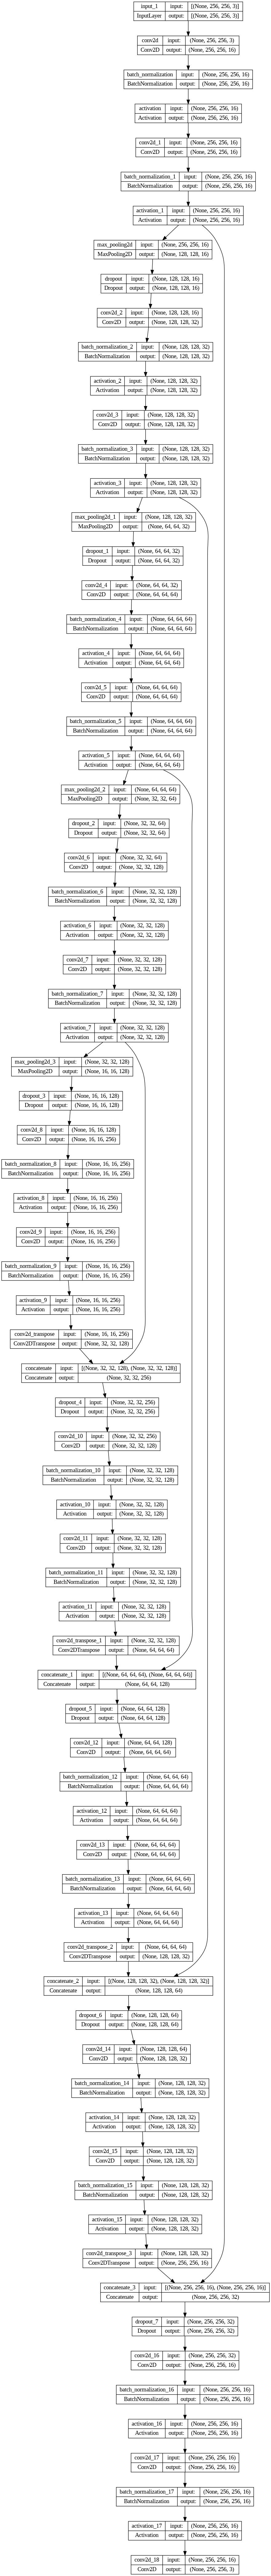

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#data_train = (train_samples["images"], train_samples["masks"])

In [ ]:
  train_samples["images"]= np.array(train_samples["images"])
  train_samples['masks']= np.array(train_samples['masks'])

In [ ]:
model_history = model.fit(train_samples["images"], train_samples["masks"], epochs=200, verbose=1)

Epoch 1/200
3/3 [==============================] - 40s 5s/step - loss: 0.8253 - accuracy: 0.2186
Epoch 2/200
3/3 [==============================] - 1s 406ms/step - loss: 0.7697 - accuracy: 0.2215
Epoch 3/200
3/3 [==============================] - 1s 403ms/step - loss: 0.7325 - accuracy: 0.2209
Epoch 4/200
3/3 [==============================] - 1s 403ms/step - loss: 0.7103 - accuracy: 0.2195
Epoch 5/200
3/3 [==============================] - 1s 393ms/step - loss: 0.6943 - accuracy: 0.2236
Epoch 6/200
3/3 [==============================] - 1s 395ms/step - loss: 0.6848 - accuracy: 0.2207
Epoch 7/200
3/3 [==============================] - 1s 397ms/step - loss: 0.6769 - accuracy: 0.2206
Epoch 8/200
3/3 [==============================] - 1s 405ms/step - loss: 0.6705 - accuracy: 0.2269
Epoch 9/200
3/3 [==============================] - 1s 396ms/step - loss: 0.6652 - accuracy: 0.2384
Epoch 10/200
3/3 [==============================] - 1s 398ms/step - loss: 0.6606 - accuracy: 0.2508
Epoch 11/20

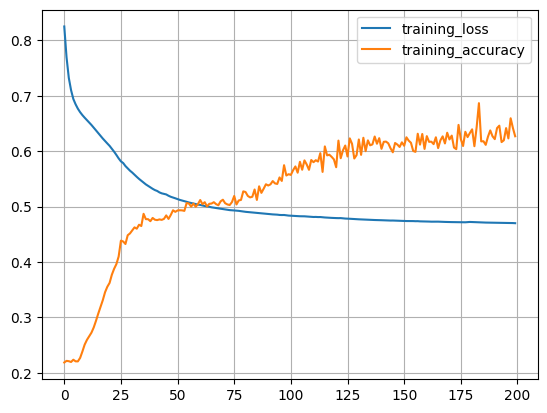

In [ ]:
plt.plot(model_history.history["loss"], label="training_loss")
plt.plot(model_history.history["accuracy"], label="training_accuracy")
plt.legend()
plt.grid(True)

# Generando predicciones con modelo de object segmentation

In [ ]:
def predict_test_samples(val_map, model):
  img = val_map["images"]
  mask = val_map["masks"]

  test_images = np.array(img)
  predictions = model.predict(test_images)

  return predictions, test_images, mask


In [ ]:
  def plot_images(test_image,predicted_mask,ground_truth):
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(test_image)
    plt.title("Image")

    plt.subplot(1,3,2)
    plt.imshow(predicted_mask)
    plt.title("Predicted mask")

    plt.subplot(1,3,3)
    plt.imshow(ground_truth)
    plt.title("Ground truth mask")

In [ ]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(test_samples, model)

1/1 [==============================] - 5s 5s/step


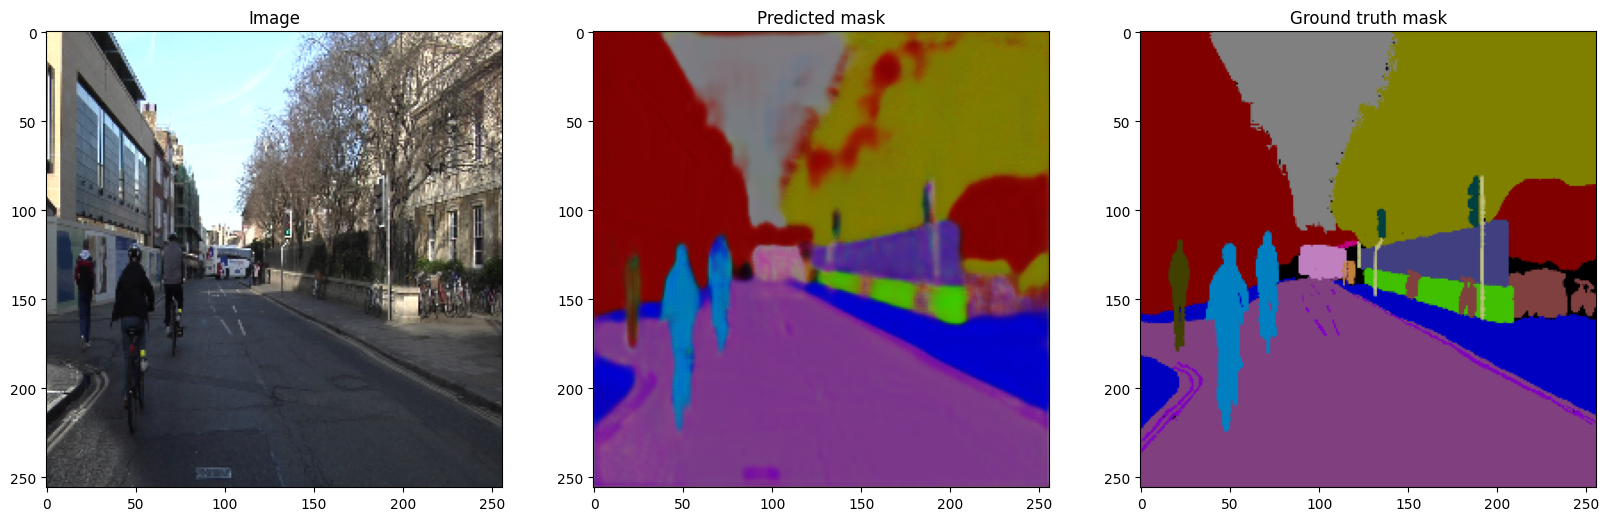

In [ ]:
plot_images(test_images[20], predicted_masks[20], ground_truth_masks[20])